# Good Reads: Item-Based Collaborative Filtering

![title](https://blog.tellwell.ca/wp-content/uploads/2016/12/goodreads.jpg)

## Overview

We cannot escape! If you use online services or buy anything from a e-commerce company, recommendation is part of your online routine. Online services are suggesting you products and services that you might like. It is everywhere. Netflix recommends shows/movies based on what you watched and recent demand. Amazon displays on your website products that you might be interested based on previous purchases, clicks, and user behavior. Youtube recommends videos and channels based on what you and others have watched. We could keep going and the idea would be the same: suggest something that you probably will enjoy.

Books are not different!! The website [goodreads.com](http://www.goodreads.com) could be defined as a social network dedicated for people interested on books. The idea is that you can interact with other readers, authors, and of course books. Between many features, the readers social network provides a members review database to give you more information for the books you are looking for. It works excatly as any other review system. You rate the book you have read (between 1 and 5 stars) and write down your opinion about it, explaining what you like or don't. I know, nothing is new here. The [goodreads.com](http://www.goodreads.com) also have its recommender system for books. It will look for the books you read and the rates you gave to suggest you new books.

In this notebook, I apply a very well known called **Item-Based Collaborative Filtering** (IBCF) technique to estimate the rate of books based on other similar books. The idea is simple, if I like a book (i.e., I rated it 5 stars) it is likely that I will also enjoy a very similar book to that one.

This technique is not new and also there are other methodologies to estimate the rates. Here we are going to focus on the IBCF and see how it works when predicting books rating!!!

## Loading and Cleaning data

In [2]:
# Display plot options
options(repr.plot.width=5, repr.plot.height=3)

# load necessary libraries
library(dplyr)
library(ggplot2)
library(tidyr)

The data is available at [Kaggle](https://www.kaggle.com/zygmunt/goodbooks-10k/data). Here we find a dataset with millions of ratings for 10k books. In this page we can also find a very good kernel about **User-Based Collaborative Filtering** (UBCF). The objective is the same, to improve the recommendations system but **UBCF** approach looks for similar users instead of books.

In [14]:
ratings<-read.csv("~/project/pre_git/goodreads/data/ratings.csv")
books<-read.csv("~/project/pre_git/goodreads/data/books.csv")

For this application we are going to use 2 datasets:

* **ratings**: Contains information about ratings. It is a simple dataset with only 3 variables: **book_id**, **user_id**, and **rating**. It is pretty straightforward. It represents the rate given from a user for a book.
* **books**: This is dataset has more information. It contains different features for books such as **title**, **author name**, **year of publication**, **number of reviews**, and etc. 

In [3]:
head(books)

id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,⋯,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008,The Hunger Games,⋯,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m/2767052.jpg,https://images.gr-assets.com/books/1447303603s/2767052.jpg
2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997,Harry Potter and the Philosopher's Stone,⋯,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m/3.jpg,https://images.gr-assets.com/books/1474154022s/3.jpg
3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005,Twilight,⋯,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m/41865.jpg,https://images.gr-assets.com/books/1361039443s/41865.jpg
4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960,To Kill a Mockingbird,⋯,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m/2657.jpg,https://images.gr-assets.com/books/1361975680s/2657.jpg
5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925,The Great Gatsby,⋯,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m/4671.jpg,https://images.gr-assets.com/books/1490528560s/4671.jpg
6,11870085,11870085,16827462,226,525478817,9.780525e+12,John Green,2012,The Fault in Our Stars,⋯,2346404,2478609,140739,47994,92723,327550,698471,1311871,https://images.gr-assets.com/books/1360206420m/11870085.jpg,https://images.gr-assets.com/books/1360206420s/11870085.jpg


In [4]:
head(ratings)

book_id,user_id,rating
1,314,5
1,439,3
1,588,5
1,1169,4
1,1185,4
1,2077,4


Let's start to clean our **ratings** dataset. It is possible for a user have more than one rating for the same book. We could assume that the user change its mind and reevalute the book rating. It definitely can happen, but for simplicity we remove these cases and assume that every combination of book and user has only one rating. In this case, we have to eliminate the cases where users gave more than on rating for the same book

In [15]:
ratings<-ratings %>% group_by(user_id, book_id) %>% mutate(total=n())
cat('Number of duplicate ratings: ', format(nrow(ratings[ratings$total > 1,]),big.mark=",",scientific=FALSE))

Number of duplicate ratings:  4,487

Example of duplicated rating: As you can see below, user **3204** rated book **8946** five times. We eliminate these cases.

In [5]:
duplicated_ratings<-ratings%>%
    group_by(book_id,user_id)%>%
    summarise(total=n())%>%
    filter(total>1)%>%
    arrange(desc(total))

head(duplicated_ratings)

book_id,user_id,total
8946,3204,5
2515,4359,4
3996,38259,4
6472,691,4
7420,34548,4
8946,42,4


As you can see above, user **3204** rated book **8946** five times. We eliminate these cases.

In [16]:
ratings <- ratings[ratings$total == 1,]

In [18]:
cat(' Number of ratings: ',format(nrow(ratings),big.mark=",",scientific=FALSE),'\n',
    'Number of Books: ',format(length(unique(ratings$book_id)),big.mark=",",scientific=FALSE),'\n',
    'Number of Users: ',format(length(unique(ratings$user_id)),big.mark=",",scientific=FALSE))

 Number of ratings:  977,269 
 Number of Books:  10,000 
 Number of Users:  53,380

For this problem, I decided to worh with books that have atleast 100 reviews, and user who gave more than 20 reviews.  Doing that I am significantly reducing reducing the number books and users. It helped me to reduce process time consumption.

In [19]:
ratings<-ratings%>%group_by(user_id)%>%mutate(total=n())%>%filter(total>20)
ratings<-ratings%>%group_by(book_id)%>%mutate(total=n())%>%filter(total==100)
cat(' Number of ratings: ',format(nrow(ratings),big.mark=",",scientific=FALSE),'\n',
    'Number of Books: ',format(length(unique(ratings$book_id)),big.mark=",",scientific=FALSE),'\n',
    'Number of Users: ',format(length(unique(ratings$user_id)),big.mark=",",scientific=FALSE))

 Number of ratings:  145,600 
 Number of Books:  1,456 
 Number of Users:  6,735

Now, we have 9,806,160 combinatations of (**book**, **user**), and only 145,600 ratings. It means that less than 2% of these possible combination have been rated.

## Understand more about our data: Descriptive analysis

### What's the most reviewed book?

In [20]:
books[books$ratings_count==max(books$ratings_count),]

id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,⋯,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008,The Hunger Games,⋯,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m/2767052.jpg,https://images.gr-assets.com/books/1447303603s/2767052.jpg


![title](https://images.gr-assets.com/books/1447303603m/2767052.jpg)

Hunger Games - Suzanne Collins with 4,780,653 reviews

### Which books has the highest average rating?

In [21]:
books[books$average_rating==max(books$average_rating),]

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,⋯,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
3628,3628,24812,24812,25599,14,740748475,9.780741e+12,Bill Watterson,2005,The Complete Calvin and Hobbes,⋯,28900,29968,861,120,154,693,3117,25884,https://images.gr-assets.com/books/1473064526m/24812.jpg,https://images.gr-assets.com/books/1473064526s/24812.jpg


![title](https://images.gr-assets.com/books/1473064526m/24812.jpg)

The Complete Calvin and Hobbes - Bill Watterson with average of **4.82** stars

### How is the rating distribution?

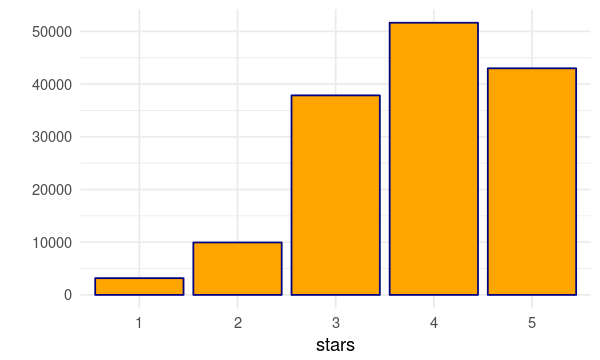

In [23]:
ratings%>%
ggplot(aes(factor(rating)))+
geom_bar(fill="orange",col="navy")+xlab("stars")+ylab("")+theme_minimal()

It seems that most of ratings are between 4-5 stars. Rarely a reader rate it as 1-2 star.

### Number of ratings by user

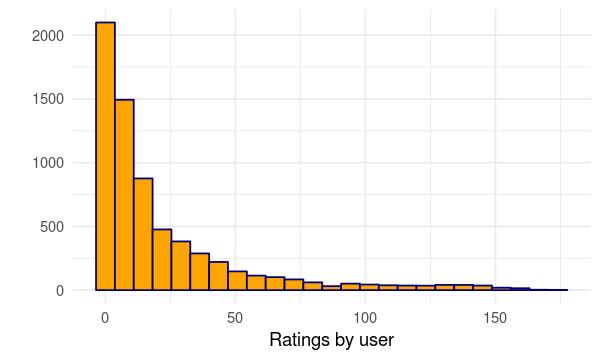

In [25]:
ratings%>%group_by(user_id)%>%summarise(total=n())%>%
ggplot(aes(total))+
geom_histogram(bins=25,fill="orange",col="navy")+theme_minimal()+xlab("Ratings by user")+ylab("")

### Rating average by user

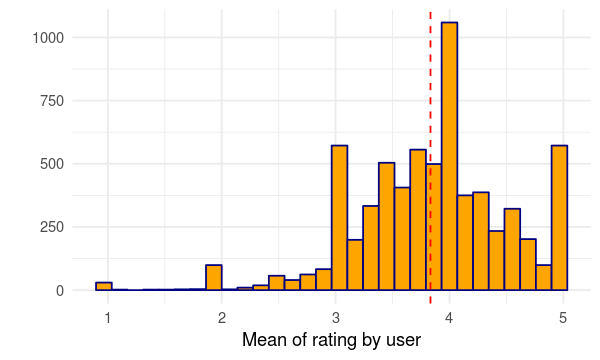

In [26]:
ratings%>%group_by(user_id)%>%summarise(rating=mean(rating))%>%
ggplot(aes(rating))+
geom_histogram(bins=30,fill="orange",col="navy")+theme_minimal()+xlab("Mean of rating by user")+ylab("")+
geom_vline(xintercept = mean(ratings$rating),col="red",lty=2)

### Rating average by book

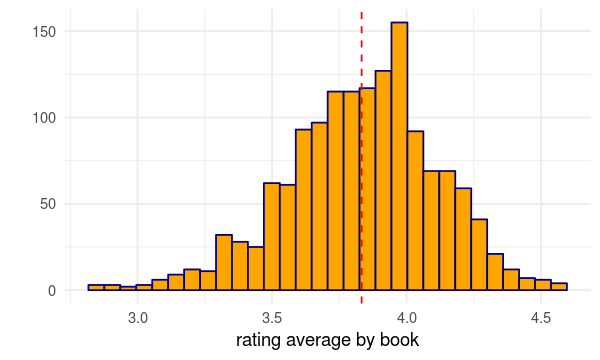

In [27]:
ratings%>%group_by(book_id)%>%summarise(rating=mean(rating))%>%
ggplot(aes(rating))+
geom_histogram(bins=30,fill="orange",col="navy")+theme_minimal()+xlab("rating average by book")+ylab("")+
geom_vline(xintercept = mean(ratings$rating),col="red",lty=2)

### Item-Based Collaborative Filter

The idea here is to suggest books that are similar to other books.

We have to create a matrix which each row represents an user and each column a book. The entries of this matrix are the the ratings. For example the element $r_{i,j}$ is the rate from the user $i$ for the book $j$.

As I mentioned before, less than 2% of the combinations of user and book are rated. It means that this matrix has a huge amount of missing data. For these cases we assume value 0.

In [29]:
#Create Matrix from Ratings dataset: rows -> user ; columns->books
rating_matrix<-spread(ratings%>%select(book_id,user_id,rating),book_id,rating)
row.names(rating_matrix)<-rating_matrix$user_id
rating_matrix<-rating_matrix[,!(names(rating_matrix)%in%"user_id")] #remove 'user_id' column

In [30]:
rating_matrix<-as.matrix(rating_matrix)

In [32]:
dim(rating_matrix)

[1] 6735 1456

In [60]:
#Rows->Users; Columns->Books
head(rating_matrix)

,1,2,3,4,5,6,7,8,9,10,⋯,4309,4333,4579,4793,4892,5195,5507,5775,7041,7150
7,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
35,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
41,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
75,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
89,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
143,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


### Similarity

How to identify if 2 books are similar? There are a lot of different ways to do this, here we are going to use the cosine similarity.

It calculates the cosine of the angle between two vectors. If the angle is *0* degrees meaning that both vectors are on the same direction the cosine is *1*. If the angle is *180* degrees it means that these vectors are in opposite directions and the cosine is *-1*.

![](https://www.safaribooksonline.com/library/view/statistics-for-machine/9781788295758/assets/2b4a7a82-ad4c-4b2a-b808-e423a334de6f.png)

What are the vectors here? A vector is the rates for a book given by all users. Some users did not read the book in this case the rate is *0*.

For example:

| Movie         | User 1| User 2| User 3| User 4| User 5|
| ------------- |:-----:|:-----:|:-----:|:-----:|:-----:|
| A             | 2     |3    |.|.|.|
| B             | 5     |    .|3|5|5|
| C             | 4     |    5|4|3|.|

The vector for the movie A is:

| User 1| User 2| User 3| User 4| User 5|
|:-----:|:-----:|:-----:|:-----:|:-----:|
| 2     |3    |0|0|0|

### recommenderLab library

The **recommenderlab** is R library providing functions to create recommendation models.

In [36]:
library("recommenderlab")

In [38]:
rating_matrix[is.na(rating_matrix)]<-0

In [61]:
sparse_rating_matrix<-as(rating_matrix,"sparseMatrix")

In [62]:
ratings <- new("realRatingMatrix", data = sparse_rating_matrix)

### Model

In [64]:
model <- Recommender(ratings, method = "IBCF",param=list(method="Cosine"))

In [65]:
model

Recommender of type ‘IBCF’ for ‘realRatingMatrix’ 
learned using 6735 users.

### Cross-Validation

Let's evaluate how our model is performing comparing to a random recommendation system.

In [73]:
scheme <- evaluationScheme(real_ratings, method = "cross-validation", k = 10, given = -1, goodRating = 5)

In [101]:
models <- list("random" = list(name = "RANDOM", param = NULL),
                   "IBCF" = list(name = "IBCF",param=list(method="Cosine")),
                   "UBCF"= list(name = "UBCF",param=list(method="Cosine"))
                   )

In [102]:
error <- evaluate(scheme, models, type = "ratings")

RANDOM run fold/sample [model time/prediction time]
	 1  [0.002sec/0.55sec] 
	 2  [0.002sec/0.517sec] 
	 3  [0.002sec/0.592sec] 
	 4  [0.002sec/0.647sec] 
	 5  [0.002sec/0.565sec] 
	 6  [0.001sec/0.561sec] 
	 7  [0.002sec/0.529sec] 
	 8  [0.001sec/0.532sec] 
	 9  [0.002sec/0.612sec] 
	 10  [0.002sec/0.556sec] 
IBCF run fold/sample [model time/prediction time]
	 1  [53.083sec/0.19sec] 
	 2  [51.356sec/0.189sec] 
	 3  [53.515sec/0.197sec] 
	 4  [49.942sec/0.189sec] 
	 5  [54.115sec/0.377sec] 
	 6  [58.095sec/0.22sec] 
	 7  [57.663sec/0.19sec] 
	 8  [55.698sec/0.194sec] 
	 9  [54.132sec/0.247sec] 
	 10  [54.339sec/0.209sec] 
UBCF run fold/sample [model time/prediction time]
	 1  [0.019sec/22.7sec] 
	 2  [0.016sec/22.781sec] 
	 3  [0.017sec/21.724sec] 
	 4  [0.017sec/21.382sec] 
	 5  [0.016sec/22.386sec] 
	 6  [0.017sec/22.766sec] 
	 7  [0.016sec/23.16sec] 
	 8  [0.017sec/22.506sec] 
	 9  [0.016sec/23.052sec] 
	 10  [0.017sec/22.739sec] 


In [120]:
lapply(unlist(lapply(results, function(x) slot(x,"results"))), function(x) x@cm[,"RMSE"])%>%
    as.data.frame()#%>%
    #gather(key="Algorithm",value="RMSE")

random1,random2,random3,random4,random5,random6,random7,random8,random9,random10,⋯,UBCF1,UBCF2,UBCF3,UBCF4,UBCF5,UBCF6,UBCF7,UBCF8,UBCF9,UBCF10
1.185968,1.200743,1.208958,1.149076,1.177499,1.20353,1.147874,1.166884,1.227453,1.168076,⋯,0.9376655,0.8903662,0.8835769,0.8972772,0.8969304,0.8856585,0.9088058,0.9031941,0.9341926,0.8647512


In [107]:
lappy(lapply(results, function(x) slot(x,"results")), function(x) slot(x,"cm"))

ERROR: Error in lappy(lapply(results, function(x) slot(x, "results")), function(x) slot(x, : could not find function "lappy"


In [103]:
tmp<-lapply(error,function(x) slot(x,"results"))
res <- tmp %>% 
  lapply(function(x) unlist(lapply(x, function(x) unlist(x@cm[ ,"RMSE"])))) %>% 
  as.data.frame() %>% 
  gather(key = "Algorithm", value = "RMSE")    

No summary function supplied, defaulting to `mean_se()
No summary function supplied, defaulting to `mean_se()


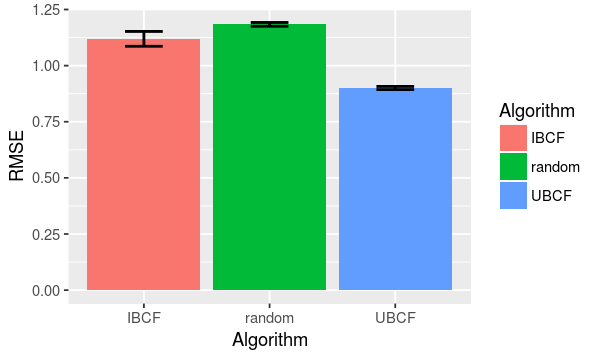

In [104]:
ggplot(res,aes(x=Algorithm,y=RMSE,fill=Algorithm))+
geom_bar(stat='summary')+geom_errorbar(stat = "summary", width = 0.3, size = 0.8)

Apperantly, we were not able to create an **IBCF** much better than a random choice. The **UBCF**, similar to the one presented on [kaggle kernel](https://www.kaggle.com/philippsp/book-recommender-collaborative-filtering-shiny/notebook), performed way better in this case. It seems that is better to find similar users than find a similar book. Maybe we could improve the results by applying other techniques. Here, the idea is to provide a simple approach and see how it works. The challenge to provide a good recommendation has been widely discussed by the comunity. Hope we